# Финальное задание модуля EDA-4 #

## Популярные статистические тесты в Python ##

Описание задания приведено в файле [README.md](README.md)

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro, normaltest
from scipy.stats import pearsonr, spearmanr, kendalltau
from scipy.stats import ttest_ind, mannwhitneyu, f_oneway, wilcoxon
from scipy.stats import probplot

### Исходные массивы данных ###

In [41]:
petersburg = [0.0974, 0.1352, 0.0817, 0.1016, 0.0968, 0.1064, 0.105]
magadan = [0.1033, 0.0915, 0.0781, 0.0685, 0.0677, 0.0697, 0.0764, 0.0689]

### 1) Объединение двух массивов в DataFrame ###

In [42]:
petersburg_ser = pd.Series(data=petersburg, dtype=float, name='petersburg')
magadan_ser = pd.Series(data=magadan, dtype=float, name='magadan')
main_df = pd.DataFrame(data={'petersburg': petersburg_ser, 'magadan': magadan_ser})
display(main_df)
display(main_df.info())

,petersburg,magadan
0,0.0974,0.1033
1,0.1352,0.0915
2,0.0817,0.0781
3,0.1016,0.0685
4,0.0968,0.0677
5,0.1064,0.0697
6,0.1050,0.0764
7,NaN,0.0689


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   petersburg  7 non-null      float64
 1   magadan     8 non-null      float64
dtypes: float64(2)
memory usage: 256.0 bytes


None

В данных по Санкт-Петербургу не хватает данных. Можно в отдельном датафрейме заполнить пустые ячейки медианным значением.

In [43]:
full_df = main_df.copy()
full_df['petersburg'].fillna(round(full_df['petersburg'].median(), 4), inplace=True)
display(full_df)

,petersburg,magadan
0,0.0974,0.1033
1,0.1352,0.0915
2,0.0817,0.0781
3,0.1016,0.0685
4,0.0968,0.0677
5,0.1064,0.0697
6,0.1050,0.0764
7,0.1016,0.0689


### 2) Тесты на нормальное распределение ##

Для эксперимента можно провести как тест Шапиро-Уилка, так и тест Д'Агостино. Здесь и далее уровень значимости устанавливается $\alpha=0,10$

Итак, тест Шапиро-Уилка:

In [44]:
def shapiro_test(data_dict):
    H0 = 'распределение нормальное'
    H1 = 'распределение не является нормальным'
    alpha = 0.1
    for city_ in data_dict.keys():
        stat, p_val = shapiro(data_dict[city_])
        if p_val > alpha:
            print(f'{city_}: p-value = {round(p_val, 3)}, значит {H0}')
        else:
            print(f'{city_}: p-value = {round(p_val, 3)}, значит {H1}')

shapiro_test({'Санкт-Перербург': petersburg, 'Магадан': magadan})

Санкт-Перербург: p-value = 0.242, значит распределение нормальное
Магадан: p-value = 0.036, значит распределение не является нормальным


Тест Д'Агостино требует минимум 8 измерений, поэтому для Санкт-Петербурга можно попробовать данные с добавленным медианным значением из **`full_df`** в качестве недостающего.

Для наглядности можно дополнительно посмотреть, насколько результат может исказиться при такой добавке:

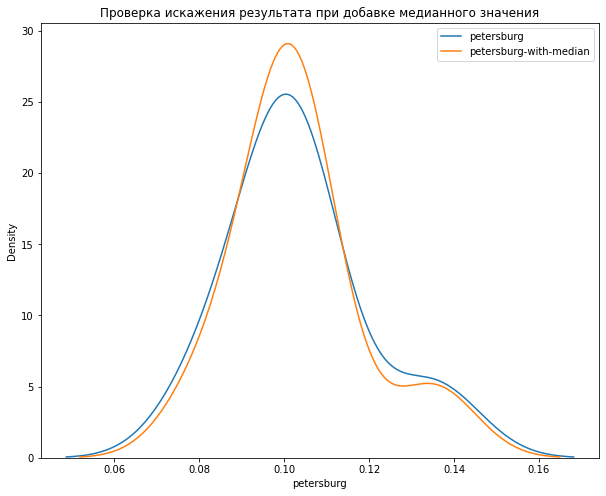

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Проверка искажения результата при добавке медианного значения')
sns.kdeplot(petersburg, ax=ax1, label='petersburg')
sns.kdeplot(full_df['petersburg'], ax=ax1, label='petersburg-with-median')
plt.legend();

Видно, что добавка медианного значения не сильно влияет на форму распределения плотности вероятности, которое заметно отличается от нормального.

Итак, тест Д'Агостино:

In [47]:
def dagostino_test(data_dict):
    H0 = 'распределение нормальное'
    H1 = 'распределение не является нормальным'
    alpha = 0.1
    for city_ in data_dict.keys():
        stat, p_val = normaltest(data_dict[city_])
        if p_val > alpha:
            print(f'{city_}: p-value = {round(p_val, 3)}, значит {H0}')
        else:
            print(f'{city_}: p-value = {round(p_val, 3)}, значит {H1}')

dagostino_test({'Санкт-Перербург': full_df['petersburg'], 'Магадан': magadan})

Санкт-Перербург: p-value = 0.035, значит распределение не является нормальным
Магадан: p-value = 0.154, значит распределение нормальное


В обоих тестах одна из групп данных не проходит тест на нормальность. Следовательно, тест Пирсона не подходит, надо использовать непараметрические тесты.

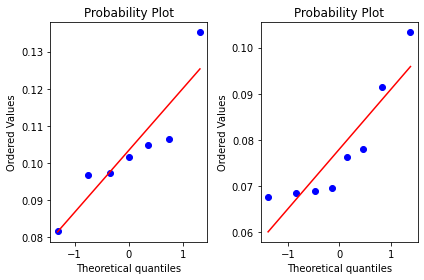

In [48]:
plt.subplot(1, 2, 1)
probplot(petersburg, plot=plt)

plt.subplot(1, 2, 2)
probplot(magadan, plot=plt)

plt.tight_layout()
plt.show();

В добавок ко всему, **q-q plot** опять показывает слабый намёк на нормальность распределения, опять недостаточно, хотя об этом можно порассуждать в конце задания.

### 3) Тест на корреляцию и его обоснование ###

- Корреляция Пирсона работает для нормального распределения количественных данных, поэтому она не годится, надо использовать непараметрические тесты.
- Можно использовать для сравнения тесты Спирмена и Кендалла. Хотя они предназначены не для количественных (как здесь), а категориальных переменных (плюс ещё&nbsp;&mdash; ранжированных), однако данных у нас так мало, что можно, как в спорном случае, условно считать их категориями.

Тесты Спирмена и Кендалла стандартным методом **Pandas** продублируем методами из **ScyPy**. Заодно убедимся, что они равнозначны. Придётся использовать данные из **`full_df`** (Без NaN-значений).

In [49]:
display(full_df.corr(method='spearman'))

corr, p = spearmanr(full_df['petersburg'], magadan, alternative='two-sided')
print(f'Коэффициент корелляции Спирмена = {round(corr, 6)}')

,petersburg,magadan
petersburg,1.000000,0.155691
magadan,0.155691,1.000000


Коэффициент корелляции Спирмена = 0.155691


In [50]:
display(full_df.corr(method='kendall'))

corr, p = kendalltau(full_df['petersburg'], magadan, alternative='two-sided')
print(f'Коэффициент корелляции Кендалла = {round(corr, 6)}')

,petersburg,magadan
petersburg,1.000000,0.181848
magadan,0.181848,1.000000


Коэффициент корелляции Кендалла = 0.181848


### 4) Вывод по гипотезе о корелляции данных ###

1. Распределение по обоим наборам данных принимаем отличным от нормального.
2. В любом случае (Спирман и Кендалл) коэффициент корелляции <&nbsp;0,3. То есть связь очень слабая или отсутствует.

### 5) Тесты на сравнение выборок и их обоснование ###

Независимый T-тест проверяет разницу между одной и той же зависимой количественной переменной (размер раковины) из разных совокупностей (то есть одна независимая категориальная переменная&nbsp;&mdash; географическое место). Кроме того,, T-тест используется на выборках размером меньше 30. То есть как раз наш случай, будем его использовать.

In [51]:
H0 = 'Нет разницы в размерах мидий из Санкт-Петербурга и Магадана'
H1 = 'Есть разница в размерах мидий из Санкт-Петербурга и Магадана'
alpha = 0.1
stat, p_value = ttest_ind(petersburg, magadan)
if p_value > alpha:
    print(f'p-value = {round(p_value, 3)}: {H0}')
else:
    print(f'p-value = {round(p_value, 3)}: {H1}')

p-value = 0.005: Есть разница в размерах мидий из Санкт-Петербурга и Магадана


Аналогичный результат выдаёт U-тест Манна-Уитни (также непараметрический):

In [52]:
H0 = 'Нет разницы в размерах мидий из Санкт-Петербурга и Магадана'
H1 = 'Есть разница в размерах мидий из Санкт-Петербурга и Магадана'
alpha = 0.1
stat, p_value = mannwhitneyu(petersburg, magadan)
if p_value > alpha:
    print(f'p-value = {round(p_value, 3)}: {H0}')
else:
    print(f'p-value = {round(p_value, 3)}: {H1}')

p-value = 0.006: Есть разница в размерах мидий из Санкт-Петербурга и Магадана


### 6) Вывод по гипотезе о разных средних размерах мидий из разных городов ###

Мы отвергаем нулевую гипотезу о равенстве размеров мидий из разных городов. Есть значимая разница между средним размером раковины мидий в Санкт-Петербурге и Магадане.

In [53]:
diff_pc = round((main_df['petersburg'].mean() - main_df['magadan'].mean()) / main_df['petersburg'].mean() * 100)
print(f'В среднем размер мидий из Магадана на {diff_pc}% меньше, чем размер мидий из Санкт-Петербурга')

В среднем размер мидий из Магадана на 25% меньше, чем размер мидий из Санкт-Петербурга


## Дополнительные выводы ##

Интересно то, что принятие нулевой гипотезы о нормальном распределении размеров мидий приводит к тому же результату из-за мизерности количества измерений. Ведь с точки зрения здравого смысла, размер мидий так же должен подчиняться нормальному распределению, как и рост человека и многие другие природные параметры.

При работе на таком датасете наглядность различий используемых тестов как-то смазывается.

In [54]:
display(main_df.describe())
std_p_pc = round(main_df['petersburg'].std() / main_df['petersburg'].mean() * 100)
std_m_pc = round(main_df['magadan'].std() / main_df['magadan'].mean() * 100)
print(f'Среднеквадратичное отклонение для Санкт-Петербурга - {std_p_pc}% от среднего значения')
print(f'Среднеквадратичное отклонение для Магадана - {std_m_pc}% от среднего значения')

,petersburg,magadan
count,7.000000,8.000000
mean,0.103443,0.078012
std,0.016209,0.012945
min,0.081700,0.067700
25%,0.097100,0.068800
50%,0.101600,0.073050
75%,0.105700,0.081450
max,0.135200,0.103300


Среднеквадратичное отклонение для Санкт-Петербурга - 16% от среднего значения
Среднеквадратичное отклонение для Магадана - 17% от среднего значения


Рассуждая оценочно, если стандартное отклонение составляет 16%, то отклонения значений (неважно&nbsp;&mdash; ошибочных от истинных, или истинных от среднего, как в этом случае) могут быть разбросаны в диапазоне $\pm40$% (так как $\sqrt{0,16}=0,4$). Поэтому нормальное распределение можно и "разглядеть" на графиках. Следовательно, ничто не запрещает нам волевым усилием задать уровень значимости (нижний предел ошибки I рода), например $\alpha=0,01$ и "подогнать" дальнейшие выводы под нормальное распределение.

In [55]:
full_df.corr(method='pearson')

,petersburg,magadan
petersburg,1.000000,0.256665
magadan,0.256665,1.000000


То есть тест Пирсона всё равно показывает слабую или отсутствующую корреляцию.

Тест ANOVA (проверяет нулевую гипотезу о том, что две или более групп имеют одинаковое среднее значение генеральной совокупности) выдаёт такой же результат по гипотезе о размерах мидий:

In [56]:
H0 = 'Нет разницы в размерах мидий из Санкт-Петербурга и Магадана'
H1 = 'Есть разница в размерах мидий из Санкт-Петербурга и Магадана'
alpha = 0.1
stat, p_value = f_oneway(petersburg, magadan)
if p_value > alpha:
    print(f'p-value = {round(p_value, 3)}: {H0}')
else:
    print(f'p-value = {round(p_value, 3)}: {H1}')

p-value = 0.005: Есть разница в размерах мидий из Санкт-Петербурга и Магадана
